In [1]:
#REFERENCES

# Kaggle tutorial: 
# https://www.youtube.com/watch?v=mPFq5KMxKVw

# Keras 
# https://keras.io/api/applications/mobilenet/

# Andrew Yang
# https://www.youtube.com/watch?v=yofjFQddwHE

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
from PIL import Image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=26x37 at 0x7F93ED97ED90>
H:  26 W:  37


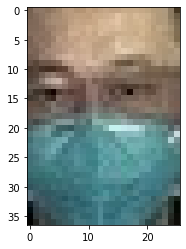

In [3]:
# initialize 

INIT_LRATE = 1e-4
EPOCHS = 12
BATCHSIZE = 32

DIRECTORY = "/Users/sashanksilwal/Downloads/Face-Mask-Detection/dataset/"
CATEGORIES = ["with_mask", "without_mask"]


data = []
labels = []
img_ = []
all_path = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, str(category))
    for img in os.listdir(path):
        
        img_path = os.path.join(path, img)
        all_path.append(img_path)
        img_.append((mpimg.imread(img_path)).size)


smallestimg = Image.open(all_path[img_.index(np.min(img_))])
print(smallestimg)
plt.imshow(smallestimg)
height, width = smallestimg.size

print("H: ",height,"W: ",width)


In [4]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)





/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [6]:

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [7]:

# construct the training image generator 
train_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [8]:
#imports the mobilenet model and discards the last 1000 neuron layer. # include top= false exclude the last layer

baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


# construct the head of the model 
xModel = baseModel.output
xModel = AveragePooling2D(pool_size=(7, 7))(xModel)
xModel = Flatten(name="flatten")(xModel)
xModel = Dense(128, activation="relu")(xModel)
xModel = Dropout(0.5)(xModel)
xModel = Dense(2, activation="softmax")(xModel)


model = Model(inputs=baseModel.input, outputs=xModel)

# loop over all layers in the base model and freeze them already pretrained
for layer in baseModel.layers:
    layer.trainable = False



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
# for i,layer in enumerate(model.layers):
#     print(i,layer.name)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
# compiling the model

optimizer_ = Adam(lr=INIT_LRATE, decay=INIT_LRATE / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=optimizer_, metrics=["accuracy"])



In [11]:
# train the head of the network
H = model.fit(
    train_generator.flow(trainX, trainY, batch_size=BATCHSIZE),
    steps_per_epoch=len(trainX) // BATCHSIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCHSIZE,
    epochs=EPOCHS)



Epoch 1/12
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
95/95 [==============================] - 1140s 12s/step - loss: 0.6692 - acc: 0.6170 - val_loss: 0.4702 - val_acc: 0.9374
Epoch 2/12
95/95 [==============================] - 1174s 12s/step - loss: 0.4958 - acc: 0.7861 - val_loss: 0.3422 - val_acc: 0.9492
Epoch 3/12
95/95 [==============================] - 1183s 12s/step - loss: 0.3907 - acc: 0.8659 - val_loss: 0.2748 - val_acc: 0.9439
Epoch 4/12
95/95 [==============================] - 1164s 12s/step - loss: 0.3145 - acc: 0.9008 - val_loss: 0.2323 - val_acc: 0.9413
Epoch 5/12
95/95 [==============================] - 1117s 12s/step - loss: 0.2746 - acc: 0.9169 - val_loss: 0.1924 - val_acc: 0.9544
Epoch 6/12
95/95 [==============================] - 1115s 12s/step - loss: 0.2354 - acc: 0.9252 - val_loss: 0.1664 - val_acc: 0.9570
Epoch 7/12
95/95 [==============================] - 1123s 12s/step - loss: 0.2126 - acc: 0.9361 - val_loss: 

In [12]:
# make predictions on the testing set
predictI = model.predict(testX, batch_size=BATCHSIZE)


In [13]:
# find the index of the label with corresponding largest predicted probability

predictI = np.argmax(predictI, axis=1)

# classification report
print(classification_report(testY.argmax(axis=1), predictI,
    target_names=lb.classes_))



              precision    recall  f1-score   support

   with_mask       0.97      0.97      0.97       383
without_mask       0.97      0.97      0.97       384

    accuracy                           0.97       767
   macro avg       0.97      0.97      0.97       767
weighted avg       0.97      0.97      0.97       767



In [14]:
# saving the model to disk
model.save("mask_detectorVGG.model", save_format="h5")

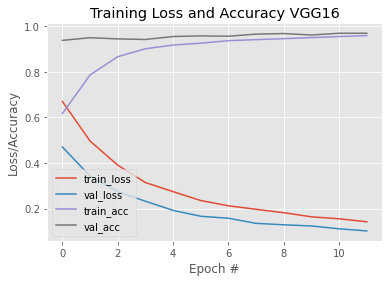

In [15]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy VGG16")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plotVGG.png")
plt.show()

In [18]:
from tensorflow.keras.utils import  plot_model



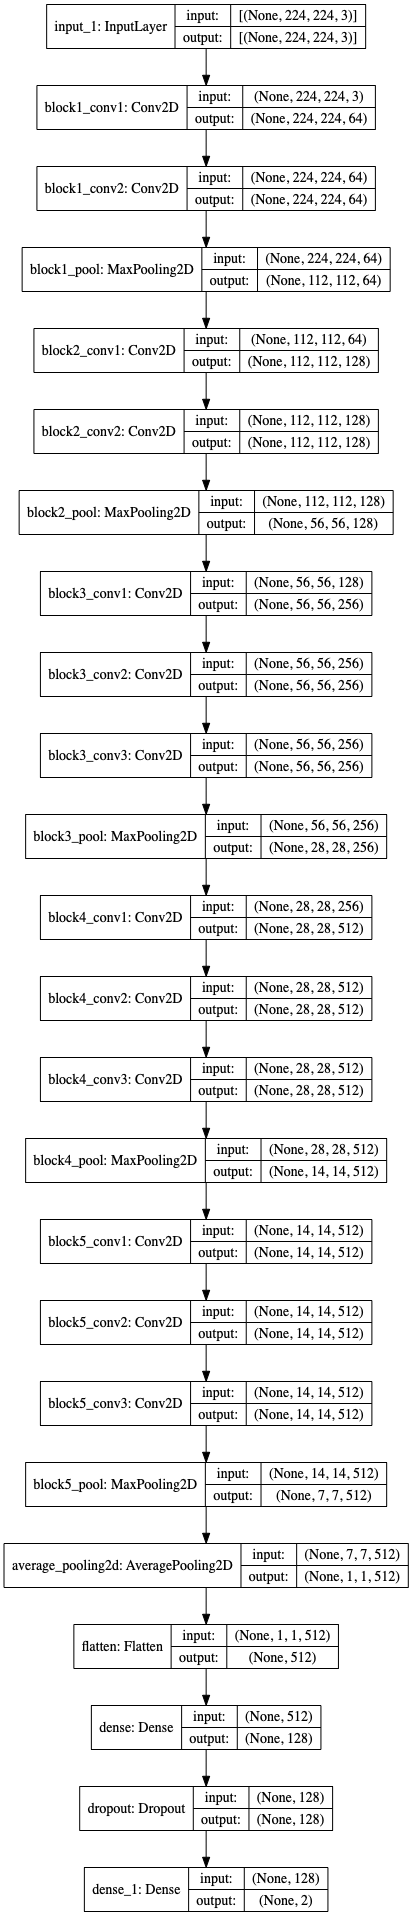

In [19]:
plot_model(model, to_file="model.png", show_shapes = True)

In [16]:
# # perform one-hot encoding on the labels
# lb = LabelBinarizer()

# labels = lb.fit_transform(labels)
# print(labels)
# print(lb)
# labels = to_categorical(labels)
# print(labels)
# data = np.array(data, dtype="float32")
# labels = np.array(labels)

In [17]:
# Our class labels are currently represented as strings; however, Keras will assume that both:

    # Labels are encoded as integers
    
    # And furthermore, one-hot encoding is performed on these labels making each label 
        # represented as a vector rather than an integer